# Simulation

Colton Gearhart

## Simulation

### Setup

In [ ]:

# load packages
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract

Loading required package: future

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()     masks purrr::discard()
✖ magrittr::extract()   masks tidyr::extract()
✖ dplyr::filter()       masks stats::filter()
✖ recipes::fixed()      masks stringr::fixed()
✖ dplyr::lag()          masks stats::lag()
✖ magrittr::set_names() masks purrr::set_names()
✖ yardstick::spec()     masks readr::spec()
✖ recipes::step()       masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

### Correlation matrix

Define functions to generate correlation matrix.

In [ ]:

# define function to generate correlation matrix of Xs
make_corr_x <- function(mc = c("ind", "low", "med-low", "med"), p = 2) {
  
  # fill in upper triangle off diagonals of the correlation matrix
  rho_xx = matrix(data = rep(NA, p^2), ncol = p)
  for(i in 1:(p-1)) {
    for (j in (i+1):p) {

      # conditionally generate pairwise correlation coefficient
      rho_xx[i,j] = 
        
        if (identical(mc, "ind")){
          
          rep(0, 1)
          
        }else if (identical(mc, "low")){
          
          runif(n = 1, min = 0, max = 0.2)
          
        }else if (identical(mc, "med-low")){
          
          runif(n = 1, min = 0.2, max = 0.4)
          
        }else if (identical(mc, "med")){
          
          runif(n = 1, min = 0.4, max = 0.6)
          
        }
    }
  }
  
  # set diagonals of correlation matrix
  diag(rho_xx) = 1
  
  # fill in lower triangle to be symmetric
  rho_xx = Matrix::forceSymmetric(rho_xx)
  
  return(as.matrix(rho_xx))
   
}

# test function
make_corr_x(mc = "med-low", p = 5)


### Simulation data

Define function to generate simulation dataset.

In [ ]:

# define function to simulate response and covariates
make_sim_data <- function(n = 100, p = 20, q = 10, b = 0.2, sigma = 1, mc = c("ind", "low", "med-low", "med")){
  
  # set multicollinearity level
  mc = match.arg(mc)
  
  # generate X correlation matrix
  rho_xx = make_corr_x(mc, p)
  
  # generate covariates
  X = MASS::mvrnorm(n = n, mu = rep(0, p), Sigma = rho_xx)
  
  # give column names
  colnames(X) = paste0("x", 1:p)
  
  # generate beta vector (q significant, non-zero parameters and p-q zeros)
  beta = c(rep(b, q), rep(0, p-q))
  
  # calculate response
  y = X %*% beta + rnorm(n, mean = 0, sd = sigma)
  
  # save as dataframe
  data_sim = data.frame(y,X)
  
  return(data_sim)
  
}


In [ ]:

# test function
tmp_data <- make_sim_data(n = 1000, p = 10, q = 5, b = 0.2, sigma = 1, mc = "med")


### Cross-validation

Define function to perform $k$-fold cross-validation: fit models on analysis data and predict for assessment data.

Then summarize each folds with the prediction measures.

In [ ]:

# for a single iteration
# perform 5-fold cross validation

# split data into 5 folds
kfolds <- rsample::vfold_cv(data = tmp_data, v = 5, repeats = 1)


In [ ]:

# function to:
# 1) fit model on analysis data
# 2) make predictions on holdout data
# ... will be the model formula
holdout_results <- function(splits, ...) {
  
  # fit the model to the analysis data (k-1 folds)
  mod_kfold = lm(..., data = rsample::analysis(splits))
  
  # save the holdout data (last fold)
  data_holdout = rsample::assessment(splits)
  
  # `augment` will save the predictions with the holdout data set
  preds = augment(mod_kfold, newdata = data_holdout)
  
  return(preds)
  
}


In [ ]:

# fit models for k-fold cross validation
kfolds$preds <- kfolds$splits %>% map(holdout_results, formula(y ~ -1 + .))

# calculate testing metrics for each fold
kfolds$results <- kfolds$preds %>% map(function(df) {
  data.frame(rmse = yardstick::rmse_vec(truth = df$y,estimate = df$`.fitted`),
             rsq = yardstick::rsq_vec(truth = df$y, estimate = df$`.fitted`))
})

# calculate final cross validation metrics
kfolds$results %>% 
  bind_rows %>% 
  summarize(across(everything(), mean))


### Set paramaters

Setup simulation structure.

In [ ]:

# initialize simulation settings with repeated iterations
# -> first the parameters of interest (constants are specified later in simulation)
# -> create all combos (+ iterations)
# -> add simulation id column
# -> organize
params_i <- expand.grid(n = seq(from = 30, to = 300, by = 10),
                        p = c(3, 6, 9),
                        q_ratio = c("1/3", "2/3", "3/3"),
                        mc = c("ind", "low", "med-low", "med"),
                        i = 1:500) %>% 
  data.frame %>% 
  group_by(n, p, q_ratio, mc) %>% 
  mutate(sim_id = cur_group_id()) %>% 
  ungroup %>% 
  arrange(sim_id, i)

# calculate specifics and organize
params_i %<>% mutate(
  q = case_when(
    q_ratio == "1/3" ~ p/3,
    q_ratio == "2/3" ~ 2*p/3,
    q_ratio == "3/3" ~ p
  ),
  mc = as.character(mc) # needed for match.args()
) %>% 
  select(sim_id, i, n, p, q_ratio, q, mc)

# nest simulation settings into dataframe
simulation <- params_i %>% 
  nest(.by = c(sim_id, i)) %>% 
  rename(params = data)


### Run simulation

In [ ]:

# run simulation
tictoc::tic()

# setup plan
plan(multisession, workers = availableCores()-4)

# generate data according to each simulation setting
# -> specify constant values in simulation (non-variable settings)
simulation$data <- simulation$params %>% future_map(function(params) {
  params %$% make_sim_data(n, p, q, mc, b = 0.2, sigma = 1)
}, .progress = TRUE, .options=furrr_options(seed = TRUE))

# split each dataset into 5 folds
simulation$kfolds <- simulation$data %>% map(\(df) rsample::vfold_cv(df, v = 5, repeats = 1), .progress = TRUE)

# loop through each iteration to work on each set of kfolds
for (j in 1:nrow(simulation)) {
  
  # extract resample dataframe
  kfolds = simulation[j, "kfolds"]$kfolds[[1]]
  
  # fit models for k-fold cross-validation
  preds = kfolds$splits %>% map(\(split) holdout_results(split, formula(y ~ -1 + .)))
  
  # calculate predictions for each fold
  results = preds %>% map(function(df) {
    data.frame(rmse = yardstick::rmse_vec(truth = df$y,estimate = df$`.fitted`),
               rsq = yardstick::rsq_vec(truth = df$y, estimate = df$`.fitted`))
  })
  
  # summarize cross-validation results
  simulation[j, "results_cv"] <- nest(
    results %>% 
    bind_rows %>% 
    summarize(across(everything(), mean))
  )
  
  if (j %% 100 == 0)
    print(j)
  
}

save(simulation, file = "files/simulation.RData")
tictoc::toc()


## Results

In [ ]:

# create results dataframe
# -> select simulation identifiers then unnest
# -> aggregate over iterations
results <- simulation %>% 
  select(sim_id, i, params, results_cv) %>% 
  unnest(cols = c(params, results_cv)) %>% 
  summarize(.by = c(sim_id, n, p, q_ratio, q, mc),
            across(c(rmse, rsq), list(mean = mean, sd = sd)))

save(results, file = "files/results.RData")


In [ ]:
load("/Users/coltongearhart/Desktop/masters-project/files/results.RData")

# set rules and the corresponding sample sizes
rules <- expand.grid(rule = c("10p", "10.8p + 11.8", "15p", "30p", "10p + 30", "p + 50", "8p + 50"),
                     p = c(3, 6, 9)) %>% 
  mutate(
    n = case_when(
      rule == "10p" ~ 10*p,
      rule == "10.8p + 11.8" ~ ceiling(10.8*p + 11.8),
      rule == "15p" ~ 15*p,
      rule == "30p" ~ 30*p,
      rule == "10p + 30" ~ 10*p + 30,
      rule == "p + 50" ~ p + 50,
      rule == "8p + 50" ~ 8*p + 50,
    )
  )


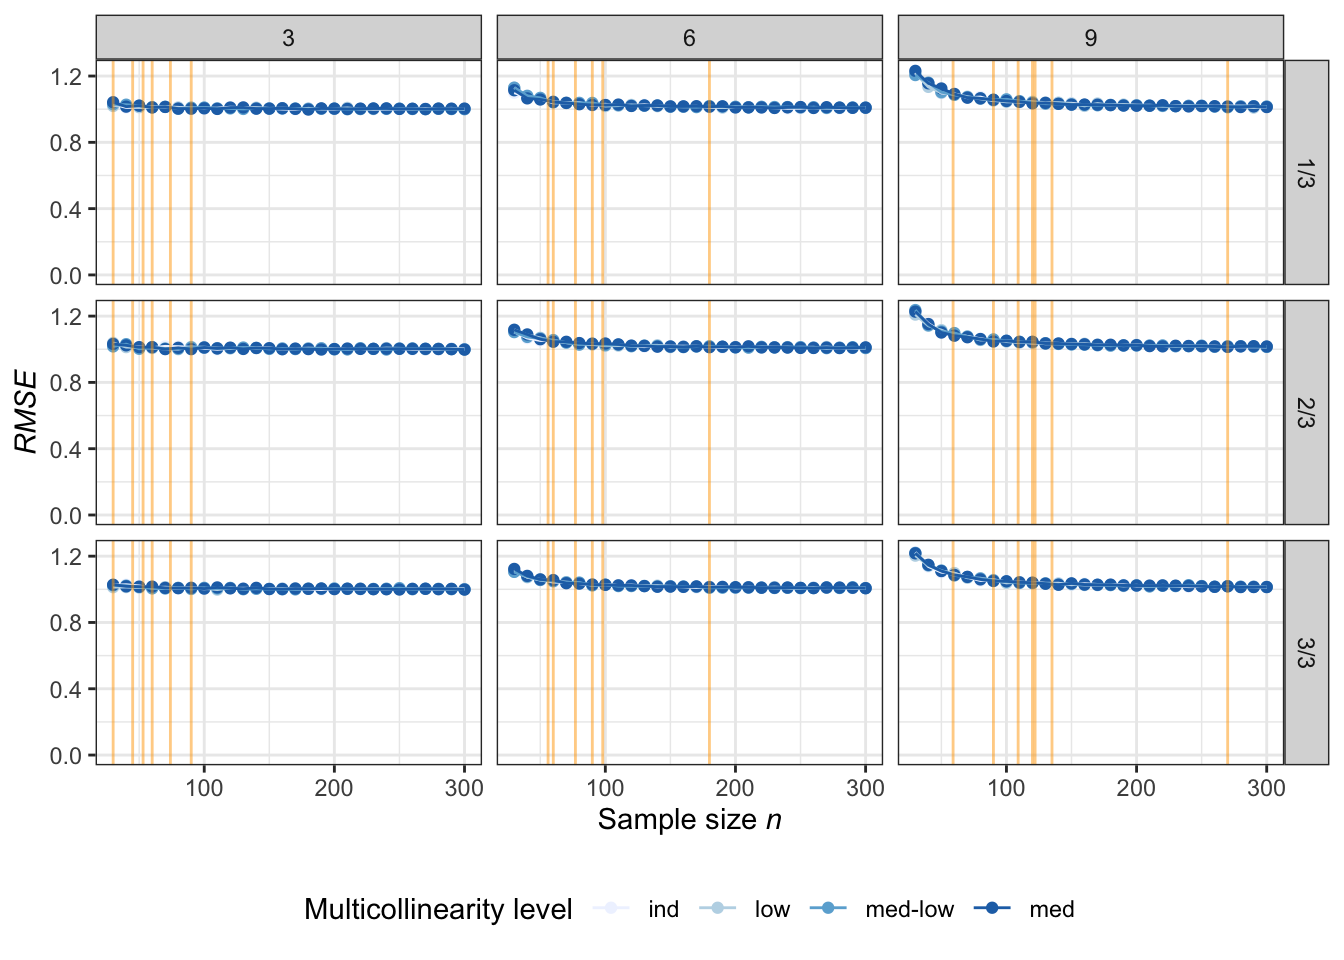

In [ ]:

# all rmse plot (panels of q ratio by p and colored by mc level)
# -> with added rules of thumb
results %>% 
  ggplot(aes(x = n,
             y = rmse_mean,
             group = factor(mc, levels = c("ind", "low", "med-low", "med")),
             color = factor(mc, levels = c("ind", "low", "med-low", "med")))) + 
  geom_point() + 
  geom_line() +
  geom_vline(aes(xintercept = n),
             data = rules,
             color = "orange",
             alpha = 0.5) + 
  scale_y_continuous(limits = c(0,NA)) + 
  scale_color_brewer() + 
  facet_grid(q_ratio ~ factor(p)) + 
  labs(x = expression("Sample size " * italic("n")),
       y = expression(italic("RMSE")),
      color = "Multicollinearity level") + 
  theme_bw() + 
  theme(legend.position = "bottom")


In [ ]:
# focused (and zoomed) rmse plot
# -> just using all active cause no q-ratio effect
p_rmse <- results %>% 
  filter(q_ratio == "3/3") %>% 
  ggplot(aes(x = n,
             y = rmse_mean,
             group = factor(mc, levels = c("ind", "low", "med-low", "med")),
             color = factor(mc, levels = c("ind", "low", "med-low", "med")))) + 
  geom_point() + 
  geom_line() +
  geom_vline(aes(xintercept = n),
             data = rules,
             color = "orange",
             alpha = 0.5) + 
  scale_color_brewer() + 
  facet_grid(q_ratio ~ factor(p)) + 
  labs(x = expression("Sample size " * italic("n")),
       y = expression(italic("RMSE")),
       color = "Multicollinearity level") + 
  theme_bw() + 
  theme(legend.position = "bottom")
  
# find the average rmse (across mc levels) from the min sample size rule to the second max
results %>% 
  filter(p == 9, q_ratio == "3/3", n %in% c(60, 140)) %>% 
  summarize(.by = n,
            mean(rmse_mean))


# A tibble: 2 × 2
      n `mean(rmse_mean)`
  <dbl>             <dbl>
1    60              1.09
2   140              1.03

# A tibble: 2 × 2
      n `mean(rmse_mean)`
  <dbl>             <dbl>
1    30              1.22
2   300              1.01

In [ ]:

ggsave("files/plot-rmse-focused.png", p_rmse)


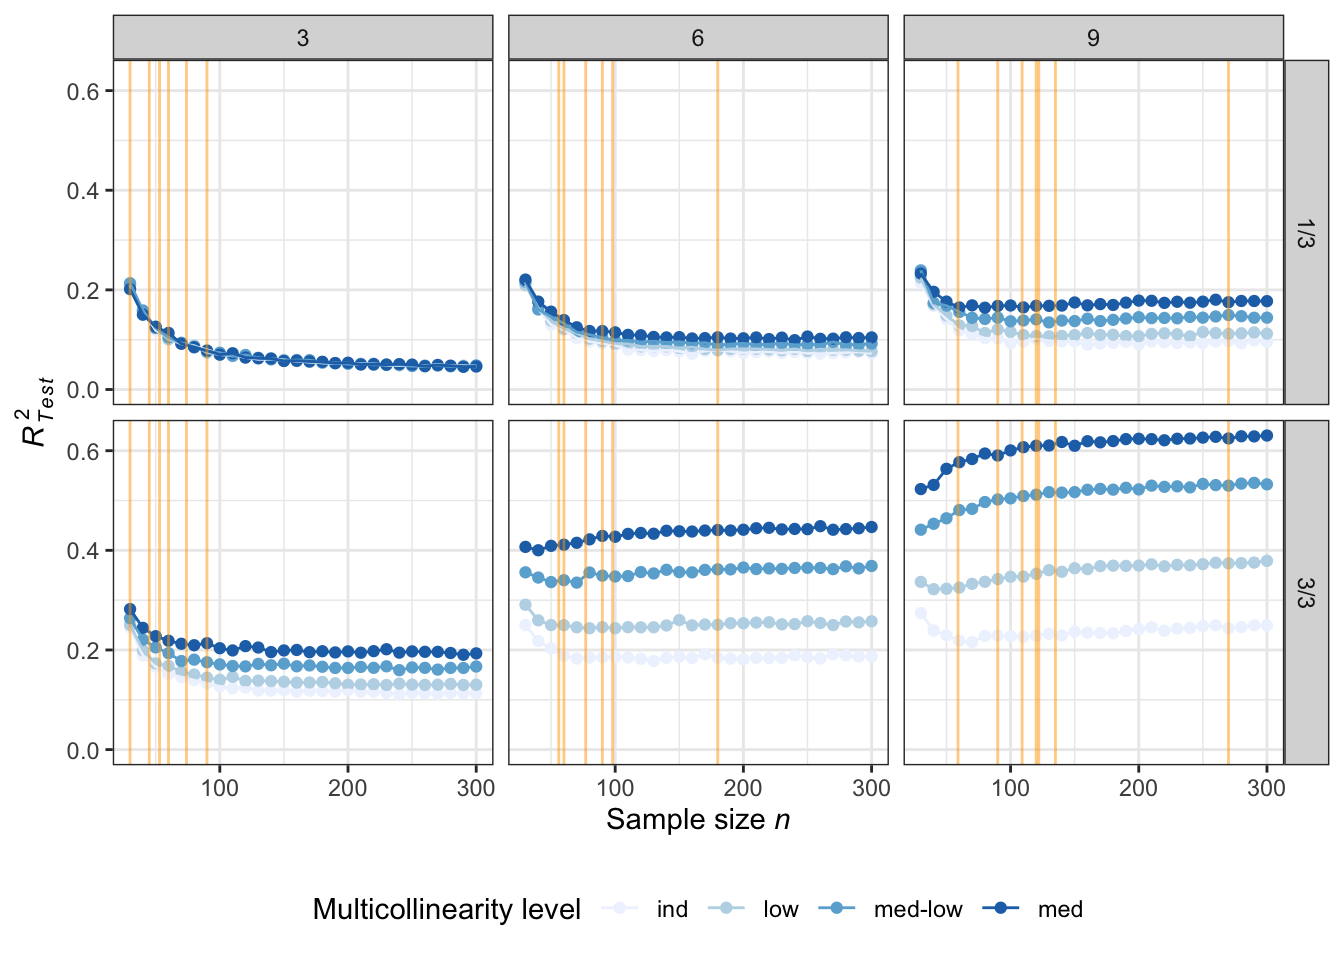

In [ ]:

# all r2 plot (panels of q-ratio by p and colored by mc level)
results %>% 
  filter(q_ratio %in% c("1/3", "3/3")) %>% 
  ggplot(aes(x = n,
             y = rsq_mean,
             group = factor(mc, levels = c("ind", "low", "med-low", "med")),
             color = factor(mc, levels = c("ind", "low", "med-low", "med")))) + 
  geom_point() + 
  geom_line() +
  geom_vline(aes(xintercept = n),
             data = rules,
             color = "orange",
             alpha = 0.5) + 
  scale_y_continuous(limits = c(0,NA)) + 
  scale_color_brewer() + 
  facet_grid(q_ratio ~ factor(p)) + 
  labs(x = expression("Sample size " * italic("n")),
       y = expression(italic(R[Test]^2)),
       color = "Multicollinearity level") + 
  theme_bw() + 
  theme(legend.position = "bottom")
